### Dependencies:

In [1]:
# %pip install --upgrade pip
# %pip install torch torchvision torchaudio
# %pip install matplotlib opencv-python scikit-learn
# %pip install gradioj

In [2]:
from pathlib import Path
import torch

# Paths
PROJECT_ROOT = Path.cwd().parent
DATA_DIR = PROJECT_ROOT / "dataset"

print("Project root:", PROJECT_ROOT)
print("Data dir exists:", DATA_DIR.exists())

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Project root: c:\Users\Jalal\Desktop\Arabic-MNIST
Data dir exists: True
Using device: cuda


If it prints False, your dataset folder is in a different place.

In [3]:
from torchvision import transforms
from torch.utils.data import DataLoader
import torchvision.datasets as datasets
import numpy as np

IMG_SIZE = 64  # we can change later if needed

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),  # ensure 1 channel
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),                        # [0,1]
    transforms.Normalize((0.5,), (0.5,)),         # roughly center around 0
])


In [4]:
import torchvision.datasets as datasets

full_dataset = datasets.ImageFolder(
    root=str(DATA_DIR),
    transform=transform
)

class_names = full_dataset.classes  # folder names like ["3ayn","7aa","faa",...]
num_classes = len(class_names)

print("Number of images:", len(full_dataset))
print("Number of classes:", num_classes)
print("Classes:", class_names)


Number of images: 15288
Number of classes: 32
Classes: ['3ayn', '7aa', 'Alif', 'baa', 'dad', 'dal', 'faa', 'ghayn', 'haa', 'hamza', 'hamzaLnbra', 'jim', 'kaf', 'khaa', 'lam', 'lamAlif', 'mim', 'non', 'qaf', 'raa', 'sad', 'shin', 'sin', 'ta2', 'ta2marbota', 'taa', 'thaa', 'waw', 'yaa', 'za2', 'zal', 'zay']


### Train/validation split & DataLoaders

In [5]:
from sklearn.model_selection import train_test_split

indices = np.arange(len(full_dataset))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=full_dataset.targets,
    random_state=42
)

# Subset wrappers
from torch.utils.data import Subset

train_dataset = Subset(full_dataset, train_idx)
val_dataset = Subset(full_dataset, val_idx)

len(train_dataset), len(val_dataset)


(12230, 3058)

In [6]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

len(train_loader), len(val_loader)


(192, 48)

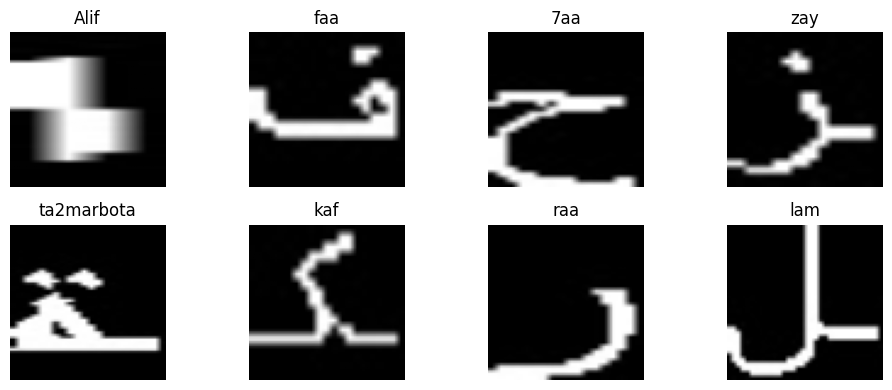

In [7]:
from matplotlib import pyplot as plt

def imshow(img_tensor, title=None):
    img = img_tensor.squeeze(0)  # (1, H, W) -> (H, W)
    img = img * 0.5 + 0.5        # unnormalize
    img = img.numpy()
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    if title is not None:
        plt.title(title)

data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow(images[i])
    plt.title(class_names[labels[i].item()])
plt.tight_layout()
plt.show()


### Define the model

In [8]:
import torch.nn as nn
import torch.nn.functional as F

class ArabicLetterCNN(nn.Module):
    def __init__(self, num_classes: int):
        super().__init__()

        # Feature extractor
        self.conv_block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1),  # 1x64x64 -> 32x64x64
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)                              # 32x32x32
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1), # 64x32x32
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)                              # 64x16x16
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),# 128x16x16
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2)                              # 128x8x8
        )

        # 128 feature maps of size 8x8 -> 128*8*8 = 8192 features
        self.fc1 = nn.Linear(128 * 8 * 8, 256)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, num_classes)

    def forward(self, x):
        # x: (B,1,64,64)
        x = self.conv_block1(x)
        x = self.conv_block2(x)
        x = self.conv_block3(x)

        x = x.view(x.size(0), -1)  # flatten

        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)            # raw logits, no softmax (CrossEntropyLoss will handle it)

        return x


### Create model, loss, optimizer

In [9]:
model = ArabicLetterCNN(num_classes=num_classes).to(device)
print(model)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Optional: for reproducibility
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


ArabicLetterCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=256, bia

### Train / eval functions

In [10]:
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


@torch.no_grad()
def evaluate(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in dataloader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        running_loss += loss.item() * images.size(0)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt


Epoch 12/12
Train Loss: 0.2896 | Train Acc: 89.57%
Val Loss:   0.1657 | Val Acc:   94.77%
Best Val Acc so far: 97.09%


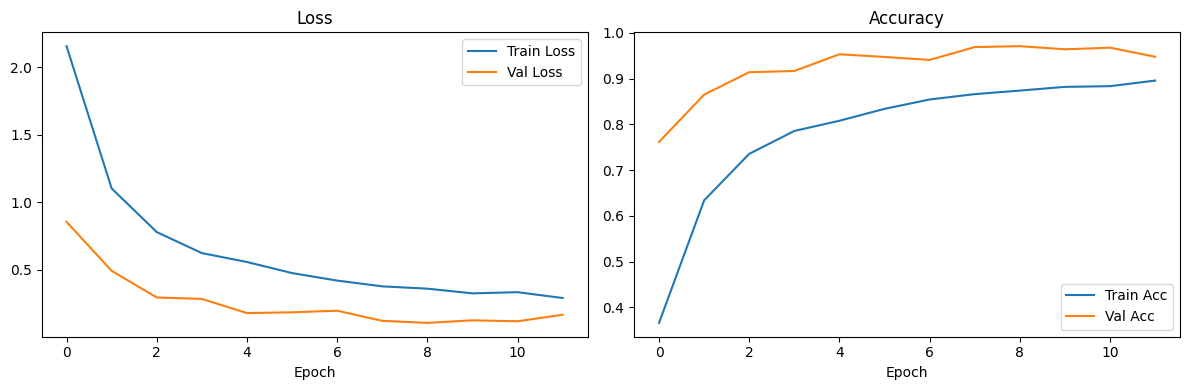


Training complete! Best model saved to: c:\Users\Jalal\Desktop\Arabic-MNIST\runs\arabic_letters_cnn.pt


In [12]:
EPOCHS = 12  # You can increase later

history = {
    "train_loss": [],
    "train_acc": [],
    "val_loss": [],
    "val_acc": [],
}

best_val_acc = 0.0
best_model_path = PROJECT_ROOT / "runs" / "arabic_letters_cnn.pt"

for epoch in range(1, EPOCHS + 1):
    # ---------------------------
    # Train & Evaluate
    # ---------------------------
    train_loss, train_acc = train_one_epoch(
        model, train_loader, optimizer, criterion, device
    )
    val_loss, val_acc = evaluate(
        model, val_loader, criterion, device
    )

    history["train_loss"].append(train_loss)
    history["train_acc"].append(train_acc)
    history["val_loss"].append(val_loss)
    history["val_acc"].append(val_acc)

    # ---------------------------
    # Save best model
    # ---------------------------
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)

    # ---------------------------
    # LIVE GRAPH UPDATE
    # ---------------------------
    clear_output(wait=True)
    
    # Text updates
    print(
        f"Epoch {epoch}/{EPOCHS}\n"
        f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc*100:.2f}%\n"
        f"Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc*100:.2f}%\n"
        f"Best Val Acc so far: {best_val_acc*100:.2f}%"
    )

    # Plot
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax[0].plot(history["train_loss"], label="Train Loss")
    ax[0].plot(history["val_loss"], label="Val Loss")
    ax[0].set_title("Loss")
    ax[0].set_xlabel("Epoch")
    ax[0].legend()

    # Acc
    ax[1].plot(history["train_acc"], label="Train Acc")
    ax[1].plot(history["val_acc"], label="Val Acc")
    ax[1].set_title("Accuracy")
    ax[1].set_xlabel("Epoch")
    ax[1].legend()

    plt.tight_layout()
    plt.show()

# final message
print(f"\nTraining complete! Best model saved to: {best_model_path}")


### Reload best model in evaluation mode

In [13]:
import torch

inference_model = ArabicLetterCNN(num_classes=num_classes).to(device)
inference_model.load_state_dict(torch.load(best_model_path, map_location=device))
inference_model.eval()

print("Loaded model from:", best_model_path)


Loaded model from: c:\Users\Jalal\Desktop\Arabic-MNIST\runs\arabic_letters_cnn.pt


In [14]:
import gradio as gr
from PIL import Image


c:\Users\Jalal\Desktop\Arabic-MNIST\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [15]:
from torchvision import transforms
import numpy as np
from PIL import Image, ImageOps

IMG_SIZE = 64  # same as training

def preprocess_gradio_image(img: np.ndarray) -> torch.Tensor:
    """
    img: numpy array from Gradio (H,W) or (H,W,3) or (H,W,4)
    returns: tensor of shape (1, 1, 64, 64)
    """
    if img is None:
        return None

    # If RGBA (H,W,4), drop alpha
    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:, :, :3]

    # Convert to grayscale
    if img.ndim == 3:
        pil_img = Image.fromarray(img.astype("uint8")).convert("L")
        img_gray = np.array(pil_img)
    else:
        img_gray = img.astype("uint8")
        pil_img = Image.fromarray(img_gray, mode="L")

    # Decide if we need to invert:
    # - Canvas drawing => white bg, dark letter => mean is high (~>127)
    # - Dataset-style => black bg, white letter => mean is low
    if img_gray.mean() > 127:
        pil_img = ImageOps.invert(pil_img)

    # Resize and normalize (same as training)
    pil_img = pil_img.resize((IMG_SIZE, IMG_SIZE))
    tensor = transforms.ToTensor()(pil_img)          # (1,64,64)
    tensor = transforms.Normalize((0.5,), (0.5,))(tensor)
    tensor = tensor.unsqueeze(0).to(device)          # (1,1,64,64)

    return tensor


In [16]:
@torch.no_grad()
def predict_letter(img: np.ndarray):
    if img is None:
        return "No image", {}

    x = preprocess_gradio_image(img)
    if x is None:
        return "Invalid image", {}

    outputs = inference_model(x)              # (1, num_classes)
    probs = torch.softmax(outputs, dim=1)[0]  # (num_classes,)
    probs_np = probs.cpu().numpy()

    pred_idx = int(np.argmax(probs_np))
    pred_label = class_names[pred_idx]  # e.g. "3ayn", "7aa", ...

    # Build a dictionary for Gradio Label / JSON-like output
    probs_dict = {
        class_names[i]: float(probs_np[i])
        for i in range(num_classes)
    }

    return pred_label, probs_dict


### Build the Gradio UI

In [17]:
import gradio as gr

sketch_input = gr.Sketchpad(
    label="Draw an Arabic letter"   # simple & compatible
)

label_output = gr.Label(num_top_classes=5)

def gradio_interface_fn(img):
    # Sketchpad may return a dict instead of a raw numpy array
    # We try the common keys used by Gradio for image-like data.
    if isinstance(img, dict):
        if "image" in img and img["image"] is not None:
            img = img["image"]
        elif "background" in img and img["background"] is not None:
            img = img["background"]
        else:
            # nothing usable
            return {}

    pred_label, probs_dict = predict_letter(img)
    return probs_dict


demo = gr.Interface(
    fn=gradio_interface_fn,
    inputs=sketch_input,
    outputs=label_output,
    title="Arabic Letter Classifier",
    description="Draw an Arabic letter, then click Submit.",
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


In [18]:
import gradio as gr

image_input = gr.Image(
    type="numpy",
    image_mode="L",
    label="Draw or upload an Arabic letter"
)

label_output = gr.Label(num_top_classes=5)

def gradio_interface_fn(img):
    pred_label, probs_dict = predict_letter(img)
    return probs_dict

demo = gr.Interface(
    fn=gradio_interface_fn,
    inputs=image_input,
    outputs=label_output,
    title="Arabic Letter Classifier",
    description="Draw an Arabic letter or upload an image, then click Submit.",
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7861
* To create a public link, set `share=True` in `launch()`.


# Show us what MODEL “sees” inside

In [19]:
import torch.nn.functional as F

@torch.no_grad()
def forward_with_activations(model, x):
    """
    Runs a forward pass and returns:
    - logits
    - feature maps after conv_block1, conv_block2, conv_block3
    """
    # Conv blocks
    x1 = model.conv_block1(x)  # (B, C1, H1, W1)
    x2 = model.conv_block2(x1) # (B, C2, H2, W2)
    x3 = model.conv_block3(x2) # (B, C3, H3, W3)

    # Flatten + FC
    flat = x3.view(x3.size(0), -1)
    h = F.relu(model.fc1(flat))
    h = model.dropout(h)
    logits = model.fc2(h)

    return logits, (x1, x2, x3)


In [20]:
import numpy as np

def feature_maps_to_grid(fmap: torch.Tensor, max_maps: int = 8, cols: int = 4):
    """
    fmap: torch tensor of shape (1, C, H, W)
    returns: numpy array (H_grid, W_grid) uint8 for Gradio Image
    """
    fmap = fmap.detach().cpu()
    if fmap.dim() != 4 or fmap.size(0) != 1:
        raise ValueError(f"Expected (1, C, H, W), got {fmap.shape}")

    fmap = fmap[0]  # (C, H, W)
    C, H, W = fmap.shape

    num_maps = min(C, max_maps)
    cols = min(cols, num_maps)
    rows = (num_maps + cols - 1) // cols

    # Prepare empty grid
    grid = np.zeros((rows * H, cols * W), dtype=np.uint8)

    for i in range(num_maps):
        fm = fmap[i].numpy()

        # Normalize each feature map to [0,255]
        fm_min, fm_max = fm.min(), fm.max()
        if fm_max > fm_min:
            fm_norm = (fm - fm_min) / (fm_max - fm_min)
        else:
            fm_norm = np.zeros_like(fm)

        fm_img = (fm_norm * 255).astype(np.uint8)

        r = i // cols
        c = i % cols
        grid[r*H:(r+1)*H, c*W:(c+1)*W] = fm_img

    return grid


In [21]:
@torch.no_grad()
def model_with_activations(img: np.ndarray):
    if img is None:
        return "No image", {}, None, None, None

    x = preprocess_gradio_image(img)
    if x is None:
        return "Invalid image", {}, None, None, None

    logits, (x1, x2, x3) = forward_with_activations(inference_model, x)

    probs = torch.softmax(logits, dim=1)[0]
    probs_np = probs.cpu().numpy()
    pred_idx = int(np.argmax(probs_np))
    pred_label = class_names[pred_idx]

    probs_dict = {
        class_names[i]: float(probs_np[i])
        for i in range(num_classes)
    }

    # Build grids for each conv block
    grid1 = feature_maps_to_grid(x1)
    grid2 = feature_maps_to_grid(x2)
    grid3 = feature_maps_to_grid(x3)

    return pred_label, probs_dict, grid1, grid2, grid3


In [22]:
def gradio_interface_fn(img):
    # unwrap dict from Sketchpad if needed
    if isinstance(img, dict):
        if "image" in img and img["image"] is not None:
            img = img["image"]
        elif "background" in img and img["background"] is not None:
            img = img["background"]
        else:
            return {}, None, None, None

    pred_label, probs_dict, grid1, grid2, grid3 = model_with_activations(img)

    # Label wants just the dict
    return probs_dict, grid1, grid2, grid3


In [23]:
import gradio as gr

sketch_input = gr.Sketchpad(
    label="Draw an Arabic letter"
)

label_output = gr.Label(num_top_classes=5)
conv1_image = gr.Image(type="numpy", image_mode="L", label="Conv Block 1 feature maps")
conv2_image = gr.Image(type="numpy", image_mode="L", label="Conv Block 2 feature maps")
conv3_image = gr.Image(type="numpy", image_mode="L", label="Conv Block 3 feature maps")

demo = gr.Interface(
    fn=gradio_interface_fn,
    inputs=sketch_input,
    outputs=[label_output, conv1_image, conv2_image, conv3_image],
    title="Arabic Letter CNN – Prediction & Layer Visualisation",
    description=(
        "Draw an Arabic letter. The model predicts the class and shows activation maps "
        "from each convolution block (first 8 channels)."
    ),
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7862
* To create a public link, set `share=True` in `launch()`.


In [24]:
import gradio as gr

# Image upload instead of drawing
image_input = gr.Image(
    type="numpy",
    image_mode="L",
    label="Upload an Arabic letter image"
)

label_output = gr.Label(num_top_classes=5)

conv1_image = gr.Image(
    type="numpy",
    image_mode="L",
    label="Conv Block 1 feature maps"
)

conv2_image = gr.Image(
    type="numpy",
    image_mode="L",
    label="Conv Block 2 feature maps"
)

conv3_image = gr.Image(
    type="numpy",
    image_mode="L",
    label="Conv Block 3 feature maps"
)

demo = gr.Interface(
    fn=gradio_interface_fn,
    inputs=image_input,
    outputs=[label_output, conv1_image, conv2_image, conv3_image],
    title="Arabic Letter CNN – Prediction & Layer Visualisation",
    description=(
        "Upload an image of an Arabic letter. "
        "The model predicts the class and shows activation maps "
        "from each convolution block (first 8 channels)."
    ),
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


# Augment Dataset

In [25]:
from torchvision import datasets

# Raw dataset: returns (PIL image, label) with NO transform
full_dataset_raw = datasets.ImageFolder(
    root=str(DATA_DIR),
    transform=None
)

class_names = full_dataset_raw.classes
num_classes = len(class_names)

print("Raw images:", len(full_dataset_raw))
print("Classes:", class_names)


Raw images: 15288
Classes: ['3ayn', '7aa', 'Alif', 'baa', 'dad', 'dal', 'faa', 'ghayn', 'haa', 'hamza', 'hamzaLnbra', 'jim', 'kaf', 'khaa', 'lam', 'lamAlif', 'mim', 'non', 'qaf', 'raa', 'sad', 'shin', 'sin', 'ta2', 'ta2marbota', 'taa', 'thaa', 'waw', 'yaa', 'za2', 'zal', 'zay']


In [26]:
from sklearn.model_selection import train_test_split
import numpy as np

indices = np.arange(len(full_dataset_raw))
targets = [full_dataset_raw.samples[i][1] for i in indices]  # labels

train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=targets,
    random_state=42
)

len(train_idx), len(val_idx)


(12230, 3058)

In [27]:
from torchvision import transforms

IMG_SIZE = 64  # same as before
PADDING = 8    # number of pixels to pad on each side

train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(PADDING, fill=0),  # black frame around letter
    transforms.RandomAffine(
        degrees=15,
        translate=(0.1, 0.1),  # up to 10% shift
        scale=(0.9, 1.1),
        shear=5,
        fill=0,                # keep background black
    ),
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])

val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.Pad(PADDING, fill=0),       # same framing
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,)),
])


### Wrap subsets with transforms

We’ll make a small helper dataset that applies a transform on top of a subset of indices.

In [28]:
from torch.utils.data import Dataset

class TransformedSubset(Dataset):
    def __init__(self, dataset, indices, transform=None):
        self.dataset = dataset
        self.indices = list(indices)
        self.transform = transform

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        img, label = self.dataset[self.indices[idx]]  # img is PIL
        if self.transform is not None:
            img = self.transform(img)
        return img, label


In [29]:
train_dataset = TransformedSubset(full_dataset_raw, train_idx, transform=train_transform)
val_dataset = TransformedSubset(full_dataset_raw, val_idx, transform=val_transform)

len(train_dataset), len(val_dataset)


(12230, 3058)

In [30]:
from torch.utils.data import DataLoader

BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


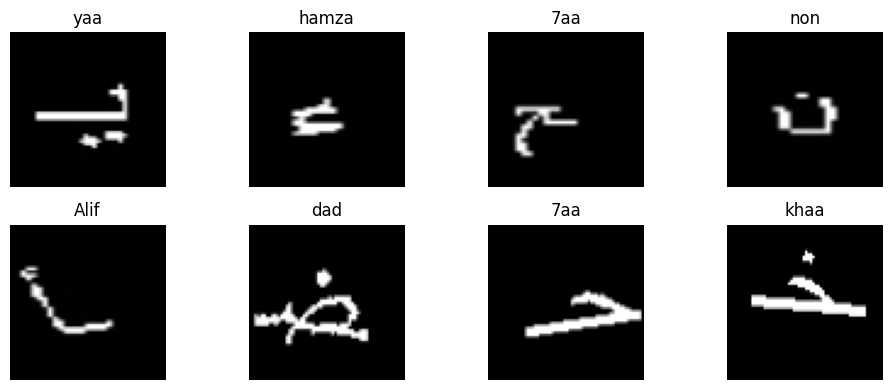

In [31]:
import matplotlib.pyplot as plt

def imshow_tensor(img_tensor, title=None):
    img = img_tensor.squeeze(0)      # (1,H,W) -> (H,W)
    img = img * 0.5 + 0.5            # unnormalize
    img = img.numpy()
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    if title is not None:
        plt.title(title)

data_iter = iter(train_loader)
images, labels = next(data_iter)

plt.figure(figsize=(10, 4))
for i in range(8):
    plt.subplot(2, 4, i + 1)
    imshow_tensor(images[i], title=class_names[labels[i].item()])
plt.tight_layout()
plt.show()


In [32]:
model = ArabicLetterCNN(num_classes=num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)


In [33]:
inference_model = ArabicLetterCNN(num_classes=num_classes).to(device)
inference_model.load_state_dict(torch.load(best_model_path, map_location=device))
inference_model.eval()


ArabicLetterCNN(
  (conv_block1): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=8192, out_features=256, bia

In [34]:
def preprocess_gradio_image(img: np.ndarray) -> torch.Tensor:
    if img is None:
        return None

    if img.ndim == 3 and img.shape[2] == 4:
        img = img[:, :, :3]

    if img.ndim == 3:
        pil_img = Image.fromarray(img.astype("uint8")).convert("L")
        img_gray = np.array(pil_img)
    else:
        img_gray = img.astype("uint8")
        pil_img = Image.fromarray(img_gray, mode="L")

    if img_gray.mean() > 127:
        pil_img = ImageOps.invert(pil_img)

    # 🔴 Use the SAME processing as val: grayscale+pad+resize+tensor+normalize
    pil_img = pil_img.convert("L")  # ensure grayscale
    tensor = val_transform(pil_img)  # (1,64,64)
    tensor = tensor.unsqueeze(0).to(device)  # (1,1,64,64)

    return tensor


In [35]:
import gradio as gr

sketch_input = gr.Sketchpad(
    label="Draw an Arabic letter"
)

label_output = gr.Label(num_top_classes=5)
conv1_image = gr.Image(type="numpy", image_mode="L", label="Conv Block 1 feature maps")
conv2_image = gr.Image(type="numpy", image_mode="L", label="Conv Block 2 feature maps")
conv3_image = gr.Image(type="numpy", image_mode="L", label="Conv Block 3 feature maps")

demo = gr.Interface(
    fn=gradio_interface_fn,
    inputs=sketch_input,
    outputs=[label_output, conv1_image, conv2_image, conv3_image],
    title="Arabic Letter CNN – Prediction & Layer Visualisation",
    description=(
        "Draw an Arabic letter. The model predicts the class and shows activation maps "
        "from each convolution block (first 8 channels)."
    ),
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7864
* To create a public link, set `share=True` in `launch()`.


In [36]:
import gradio as gr

# Image upload instead of drawing
image_input = gr.Image(
    type="numpy",
    image_mode="L",
    label="Upload an Arabic letter image"
)

label_output = gr.Label(num_top_classes=5)

conv1_image = gr.Image(
    type="numpy",
    image_mode="L",
    label="Conv Block 1 feature maps"
)

conv2_image = gr.Image(
    type="numpy",
    image_mode="L",
    label="Conv Block 2 feature maps"
)

conv3_image = gr.Image(
    type="numpy",
    image_mode="L",
    label="Conv Block 3 feature maps"
)

demo = gr.Interface(
    fn=gradio_interface_fn,
    inputs=image_input,
    outputs=[label_output, conv1_image, conv2_image, conv3_image],
    title="Arabic Letter CNN – Prediction & Layer Visualisation",
    description=(
        "Upload an image of an Arabic letter. "
        "The model predicts the class and shows activation maps "
        "from each convolution block (first 8 channels)."
    ),
)

demo.launch()


* Running on local URL:  http://127.0.0.1:7865
* To create a public link, set `share=True` in `launch()`.
